# Deep Convolutional GAN példa
Ezen architektúra természetesen a mai eredmények mellett egyszerűnek tűnhet elsőre, viszont a későbbi, fejlettebb architektúrákban többségében megfigyelhető, hogy erre építkeztek. Természetesen az architektúra egy igen egyszerű kiegészítést kínált az eredeti GAN hálózatra: konvolúciós rétegeket alkalmaz a rejtett rétegekben mind a Generátor, mind a Diszkriminátor esetében. A konvolúciós rétegek segítségével a képeken lévő összefüggő pixelek kapcsolatairól pontosabb reprezentációt kaphatunk, így képek generálásához is hasznos lehet a módszer.


<img src="images/DCGAN.png" width="100%">

In [1]:
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import matplotlib.ticker as ticker
import numpy as np

2022-04-25 17:18:34.108909: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-25 17:18:34.108997: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import actplot.plotter as actplt

## Generátor
Az osztályozáshoz használt konvolúciós hálókkal ellentétben a Generátorban a kisebb felbontás felől haladunk a nagyobb felbontásig.
A generátor modellem első implementációjában _Dekonvolúciós_ rétegeket alkalmaztam, amelyet _Transzponált konvolúciós_ rétegnek is nevezhetünk. A Dekonvolúciós rétegek segítségével minden rejtett réteg kimenete egy nagyobb felbontású kép lesz, ellentétben a konvolúció működésével. Tehát a hálónak jelen esetben meg kell tanulnia a rétegekben az optimális felbontás-növelést. Előre megadott paraméterek a filterek darabszáma, a kernel mérete, a strides(?) és a padding. Ha a padding-ot "same"-re és ha a strides paramétert 2x2-esnek választjuk, úgy a réteg kimenetén megjelenő kép felbontása kétszerese lesz a bemeneti oldalon megfigyelhető képnek. A rejtett rétegekben kezdetben ReLU aktivációs függvényt használtam, a neuronok kezdő értékeit a He inicializációs technikával állítottam be (Hands on könyv ajánlása alapján).

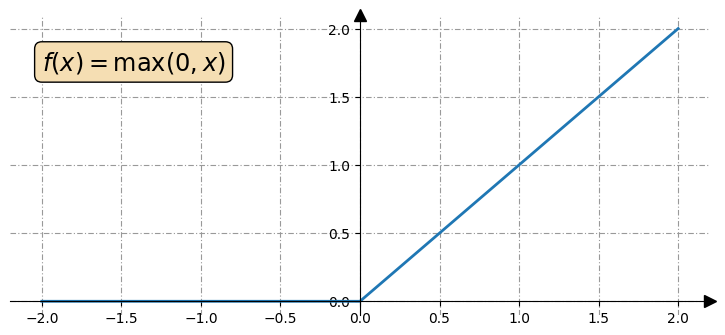

In [3]:
actplt.plot_relu()

A tanításhoz célszerű a kép pixeleinek intenzitását normalizálni a [-1, 1] intervallumra. A Generátor is ebben az intervallumban fogja a képek pixeleit generálni a hiperbolikus tanges kimeneti aktivációs függvényéből adódóan. (tanh indoklás, sigmoid helyett..) A megjelenítéshez később természetesen denormalizálnunk kell a generált képek pixelértékeit a [0, 255] tartományra.

A Generátor modell bemenetként az előre definiált látens tér dimenziójával megegyező dimenziójú zajt kap. Majd ezen bemeneti zaj segítségével állítja össze a megfelelő kimeneti képet. A tanulás során tehát a látens tér tartományaihoz rendeli a tanult jellegzetességeket és a látens teret mintavételezve dekódolható a Generátor segítségével a ponthoz tartozó kép.

A bemeneti zaj egy Reshape rétegen megy keresztül, amelyben a látens tér dimenziószámát átformázza egy 1x1xLdim dimenziójú mátrixá. Ezen réteg kimenetével a későbbi dekonvolúciós rétegek már tudnak dolgozni.
Ezután az első dekonvolúciós rétegen megy át a kapott mátrix, amely 512 darab filtert tartalmaz, 4x4-es kernelméretekkle dolgozik és 'valid' paddingot használ. Az aktivációs függvénye ReLU a már említett He inicializálással. Ezen lépés arra szolgál, hogy a látens térből előállítson egy 4x4x512-es tensort, amely az első, legkisebb felbontású képünknek tekinthetjük ebben az esetben, ahol a színcsatornák száma 512 és a felbontása 4x4.

A Generátorban ezután 2x2-es stride értékeket használva a kívánt felbontásig dekonvolúciós rétegeken keresztül növekszik a felbontás. A kernel méretét a rétegekben egységesen 4x4-ra állítottam be, a paddig 'same' és a strides a már említett 2x2-es. Az aktivációs függvény szintén ReLU. A rétegekben haladva a filterek darabszáma pedig feleződik. A filterek optimális számára csupán csak empirikus eredményeket találtam. Az utolsó dekonvolúciós réteg 3 darab filterrel rendelkezik.

A kimeneti képnek olyan tulajdonságokkal kell rendelkeznie, mint a tanítómintában szeplő képeknek. Például ha a tanítóminta színes képekből áll, rgb színkeveréssel, vagyis három színcsatornával, úgy a Generátor kimenetén is ilyen képekre van szükségünk. Mivel az említett dekonvolúciós rétegek több mint 3 színcsatornával dolgoztak, a megjeleníthetőség miatt szükséges tehát az utolsó dekonvolúciós rétegben a 3 darab filter.
Végül a hiperbolikus tangens aktivációs függvény hatására az eredményeket a [-1, 1] intervallumba transzformálja.

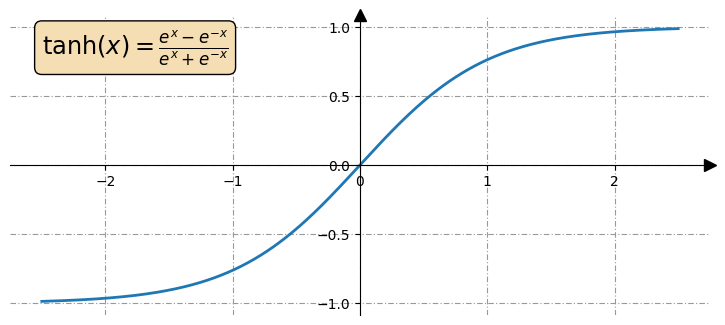

In [4]:
actplt.plot_tanh()

In [5]:
# Látens tér dimenziószáma
latent_dim = 100

# Bemeneti zaj generálása
noise = tf.random.normal([1, latent_dim])

2022-03-29 13:41:20.962328: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-29 13:41:20.962393: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-29 13:41:20.962443: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Inspiron-5558): /proc/driver/nvidia/version does not exist
2022-03-29 13:41:20.964854: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
input_noise = keras.layers.Input(shape=[latent_dim])

hidden = keras.layers.Reshape((1, 1, latent_dim))(input_noise)

hidden = keras.layers.Conv2DTranspose(512, (4, 4), (1, 1), 'valid', kernel_initializer="he_normal")(hidden)
hidden = keras.layers.ReLU()(hidden)
    
hidden = keras.layers.Conv2DTranspose(256, (4, 4), (2, 2), 'same', kernel_initializer="he_normal")(hidden)
hidden = keras.layers.ReLU()(hidden)
    
hidden = keras.layers.Conv2DTranspose(128, (4, 4), (2, 2), 'same', kernel_initializer="he_normal")(hidden)
hidden = keras.layers.ReLU()(hidden)

hidden = keras.layers.Conv2DTranspose(64, (4, 4), (2, 2), 'same', kernel_initializer="he_normal")(hidden)
hidden = keras.layers.ReLU()(hidden)
    
hidden = keras.layers.Conv2DTranspose(3, (4, 4), (2, 2), 'same')(hidden)
out = keras.layers.Activation("tanh")(hidden)
    
generator = keras.Model(inputs=input_noise, outputs=out)

In [7]:
tf.random.set_seed(22)

generator = keras.Sequential([
    keras.layers.Reshape((1, 1, latent_dim), input_shape=[latent_dim]),
    keras.layers.Conv2DTranspose(512, (4, 4), (1, 1), 'valid',
                                 activation="relu",
                                 kernel_initializer="he_normal"),
    keras.layers.Conv2DTranspose(256, (4, 4), (2, 2), 'same',
                                 activation="relu",
                                 kernel_initializer="he_normal"),
    keras.layers.Conv2DTranspose(128, (4, 4), (2, 2), 'same',
                                 activation="relu",
                                 kernel_initializer="he_normal"),
    keras.layers.Conv2DTranspose(64, (4, 4), (2, 2), 'same',
                                 activation="relu",
                                 kernel_initializer="he_normal"),
    keras.layers.Conv2DTranspose(3, (4, 4), (2, 2), 'same',
                                 activation="relu"),
    keras.layers.Activation("tanh")
])

In [8]:
print(generator.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 1, 1, 100)         0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 4, 4, 512)         819712    
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 8, 8, 256)         2097408   
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 16, 16, 128)       524416    
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 32, 32, 64)        131136    
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 64, 64, 3)         3075      
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 3)         0

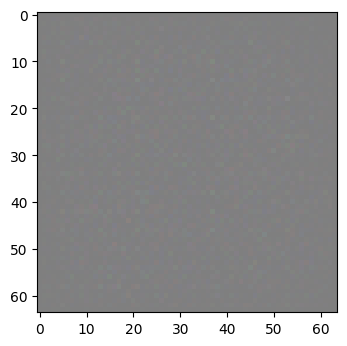

In [9]:
generated_images = generator(noise, training=False)
gen_1 = (generated_images[0].numpy() * 127.5 + 127.5).astype("uint32")

fig = plt.figure(figsize=(3, 3), dpi=100)
ax = fig.add_axes([0, 0, 1, 1])
ax.imshow(gen_1)

## Diszkriminátor

A Diszkriminátor modell lényegében egy bináris osztályozó, amely eldönti, hogy a bemenetül kapott kép valódi vagy hamis. A bemeneti kép konvolúciós rétegeken megy végig, majd a kimeneti rétegen sigmoid aktivációs függvény segítségével hozza meg a döntést. A konvolúciós rétegek segítségével a modell fel tudja tárni a képeken található jellegzetességeket. A képen található mintázatokat filterek segítségével tanulja meg, amelyek megadott kernelméretekben pásztázzák végig a bemenetet. Így az egyes konvolúciósrétegek kimeneteként egy olyan reprezentáció jön létre a bemeneti képről, amelyben érvényesülnek a pixeleket körülölelő további pixelek kapcsolatai is. Ezáltal a kimeneti aktivációs függvény előtti réteg, a szerializáció (Flattening) kevésbé fogja a kép tartalmára vonatkozó információt rontani. Mivel a tanítóminta képeinek pixelértékeit normalizáltuk a [-1, 1] intervallumra, így a diszkriminátor a bemenetén is ilyen tulajdonságú képeket vár. A Diszkriminátor felépítésben hasonlít a Generátorhoz, lényegében annak tükörképeként képzelhetjük el. Viszont a dekonvolúciós rétegek helyett konvolúciós rétegeket alkalmazunk benne.

Lényeges leírni részletesen, hogy hogy épül fel?


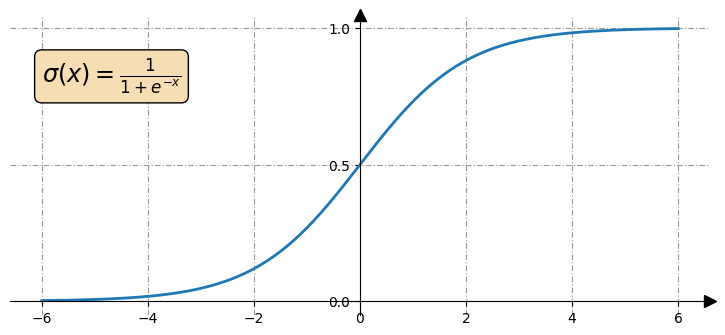

In [10]:
actplt.plot_sigmoid()

In [14]:
discriminator = keras.Sequential([
    keras.layers.Conv2D(64, (4, 4), (2, 2), "same",
                        input_shape=(64, 64, 3), activation="relu",
                        kernel_initializer="he_normal"),
    keras.layers.Conv2D(128, (4, 4), (2, 2), "same",
                        activation="relu",
                        kernel_initializer="he_normal"),
    keras.layers.Conv2D(256, (4, 4), (2, 2), "same",
                        activation="relu",
                        kernel_initializer="he_normal"),
    keras.layers.Conv2D(512, (4, 4), (2, 2), "same",
                        activation="relu",
                        kernel_initializer="he_normal"),
    keras.layers.Conv2D(100, (4, 4), (1, 1), "valid",
                        activation="relu"),
    keras.layers.Flatten(),
    keras.layers.Dense(1)
])

In [12]:
print(discriminator.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        3136      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       131200    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 256)         524544    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 512)         2097664   
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 1, 100)         819300    
_________________________________________________________________
flatten (Flatten)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                

**Generátor**

| Réteg                                | Aktivációs függvény | Kimenet alakja |
| :----------------------------------- | :-----------------: | -------------: |
| Input                                | -                   | (100)          |
| Reshape                              | -                   | (1, 1, 100)    |
| (4 x 4) ConvT, (1 x 1) stride, valid | ReLU                | (4, 4, 512)    |
| (4 x 4) ConvT, (2 x 2) stride, same  | ReLU                | (8, 8, 256)    |
| (4 x 4) ConvT, (2 x 2) stride, same  | ReLU                | (16, 16, 128)  |
| (4 x 4) ConvT, (2 x 2) stride, same  | ReLU                | (32, 32, 64)   |
| (4 x 4) ConvT, (2 x 2) stride, same  | tanh                | (64, 64, 3)    |

Paraméterek száma: **3.5 millió**

**Diszkriminátor**

| Réteg                                | Aktivációs függvény | Kimenet alakja |
| :----------------------------------- | :-----------------: | -------------: |
| Input                                | -                   | (64, 64, 3)    |
| (4 x 4) Conv, (2 x 2) stride, same   | ReLU                | (32, 32, 64)   |
| (4 x 4) Conv, (2 x 2) stride, same   | ReLU                | (16, 16, 128)  |
| (4 x 4) Conv, (2 x 2) stride, same   | ReLU                | (8, 8, 256)    |
| (4 x 4) Conv, (2 x 2) stride, same   | ReLU                | (4, 4, 512)    |
| (4 x 4) Conv, (1 x 1) stride, valid  | ReLU                | (1, 1, 100)    |
| Flatten                              | -                   | (100)          |
| Dense(1)                             | Sigmoid             | (1)            |

Paraméterek száma: **3.5 millió**

## Tanítás, mérések

A felvázolt architektúrát tanítva a hibaértékek a következő ábrához hasonlóan alakulnak:

In [2]:
gen_losses = np.load("datas/losses/dcgan/gen_losses.npy")
disc_losses = np.load("datas/losses/dcgan/disc_losses.npy")

batch_size = 16

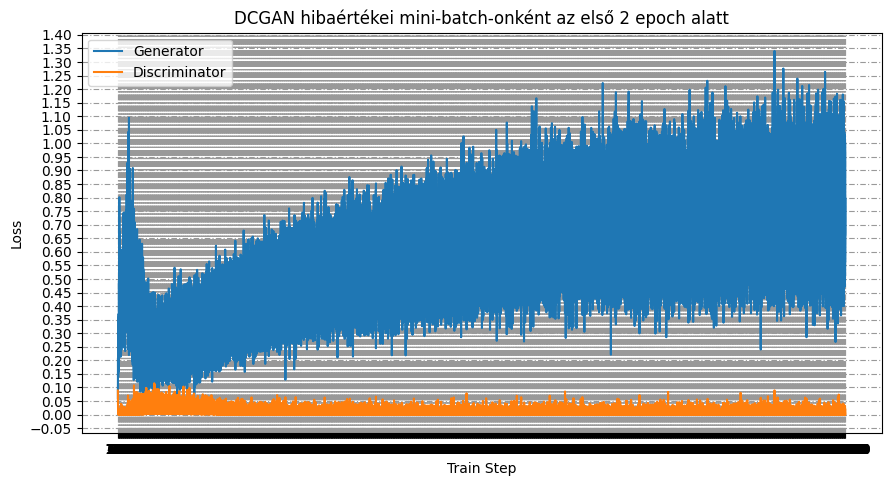

In [8]:
epochs = 2
trainsteps = gen_losses.shape[1] * epochs

gen = gen_losses[:epochs].flatten() / batch_size
disc = disc_losses[:epochs].flatten() / batch_size

fig_1 = plt.figure(figsize=(8, 4), dpi=100)
ax = fig_1.add_axes([0, 0, 1, 1])
ax.set_xlabel('Train Step')
ax.set_ylabel('Loss')
ax.set_title('DCGAN hibaértékei mini-batch-onként az első 2 epoch alatt')
ax.plot(np.linspace(1, trainsteps, trainsteps), gen, label='Generator')
ax.plot(np.linspace(1, trainsteps, trainsteps), disc, label='Discriminator')
ax.legend(loc=0)

ax.grid(True, color='0.6', dashes=(5, 2, 1, 2))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))

x_ticks = np.arange(0, trainsteps+1, 100)
x_ticks[0] = 1
ax.set_xticks(x_ticks)

plt.show()


A modell tanítása nehézkes lehet, ezt kívánom szemléltetni a fenti ábrákkal.
Jól látható, hogy a tanítási folyamat során igen érdekes hibaértékek születnek. Egy tanítási lépés egy minibatch-on történő tanítást jelent, egy epoch pedig az összes minibatch-on való tanítást jelenti.
Ha csak a nyers hibaértékre tekintünk, akkor azt figyelhetjük meg, hogy a tanítási lépések között erősen oszcillálnak az értékek. Kijelenthetjük a látott eredmények alapján, hogy a tanítás valóban nem stabil és egészen random módon változhatnak az értékek.
A szemléltetés kedvéért a következő ábrán a minibatchokon számolt hibaértékek átlagait figyelhetjük meg epoch-onként.

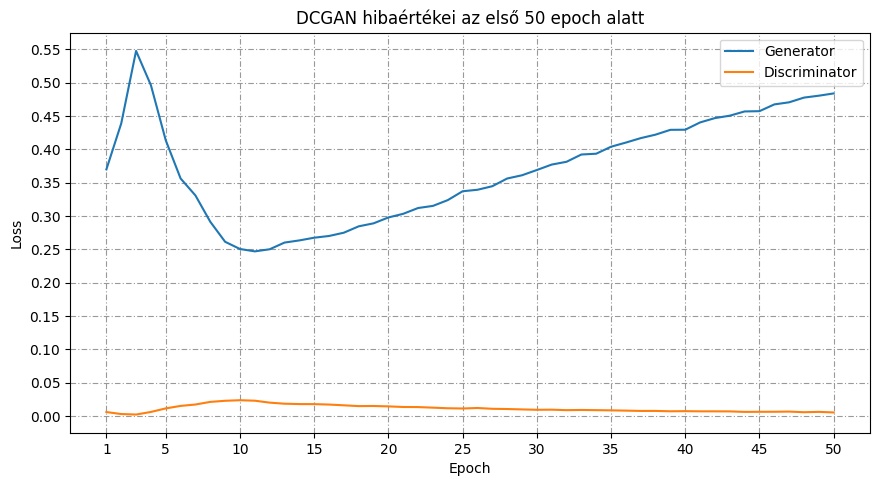

In [19]:
epochs = 50

gen = gen_losses[:epochs].mean(axis=1) / batch_size
disc = disc_losses[:epochs].mean(axis=1) / batch_size

fig_1 = plt.figure(figsize=(8, 4), dpi=100)
ax = fig_1.add_axes([0, 0, 1, 1])
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('DCGAN hibaértékei az első 50 epoch alatt')
ax.plot(np.linspace(1, epochs, epochs), gen, label='Generator')
ax.plot(np.linspace(1, epochs, epochs), disc, label='Discriminator')
ax.legend(loc=0)

ax.grid(True, color='0.6', dashes=(5, 2, 1, 2))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))

x_ticks = np.arange(0, epochs+1, 5)
x_ticks[0] = 1
ax.set_xticks(x_ticks)
plt.show()

Így finomabb görbéket kapunk, viszont erősen torzít az ábra, hiszen a GAN tanítási folyamata nem ilyen rendezett, mint ahogyan az első ábrán is láthattuk.
A hibaértékek változását vizsgálva megfigyelhető a versengés, vagyis hogy a két hálózat hibái mennyire ellentétesen mozognak az epoch-ok alatt. Mivel a tanulás során függőség van a két hálózat között, így ha a diszkriminátor egy vizsgált epoch alatt rosszabbul teljesítene a korábbi eredményekhez képest, akkor a generátor hibaértéke alacsonyabb lesz és fordítva. A generátor hibái többszörösek lehetnek a diszkriminátor hibáinak, de ez a jelenség teljesen természetes, hiszen a generátor lényegében a másik hálózat hibáiból tud csak tanulni, hiszen a tanulás során nem látja a tanítóminta elemeit. A generátorban megfigyelhető, egyre növekvő hibaérték ellenére a generált képek minősége és részletezettsége is növekedni fog.

A hibaértékekből nem vonhatunk le pontos következtetéseket, így a fenti ábrák csupán szemléltetésképp készültek el. A GAN teljesítményének mérésére egyéb ajánlások jelentek meg. (Amelyeket szerintem egy külön fejezetben kéne összefoglalnom...)

## Problémák

A modell természetesen bővíthető tetszőlegesen nagy felbontásig, a felbontást növelő rétegek számával. Viszont az architektúrával problémák léphetnek fel:
- A modell ebben a formájában igen hajlamos az mode collapse-re, vagyis a tanulás során jelentkező összeomlásra.
- A konvolúciós rétegek működéséből adódóan csupán lokális pixel-környezetekre képes összefüggő részeket generálni a modell.
	Ez a működés alacsony felbontás mellett is anomáliákat idézhet elő, ilyen a képeken megfigyelhető ismétlődő, sakktmintás zaj. Ha a rejtett konvolúciósrétegek számával növelnénk a felbontást, akkor további nehézségbe is ütközünk: a modell nem lesz képes felismerni és megtanulni a tanítóminta képein megfigyelhető távoli, összefüggő tulajdonságokat. Így a generált képek részletezettsége alacsony lesz, gyakran blobokat figyelhetünk meg csupán, különböző textúrákkal. A globális összefüggőségre több javaslat is érkezett a DCGAN megjelenése óta...
- A modellnek nincsen információja a különféle osztályokról, csupán a képek rendezettlen halmazán tanul, így magától kell megtanulnia a különféle osztályok jellegzetességeit.
	Az általánosítás szempontjából ez előnyös is lehet, viszont ha merőben különböző osztályokra szeretnénk betanítani a modellt, akkor az úgynevezett \textit{class conditoning} nélkül ezt igen nehezen tudnánk megvalósítani.


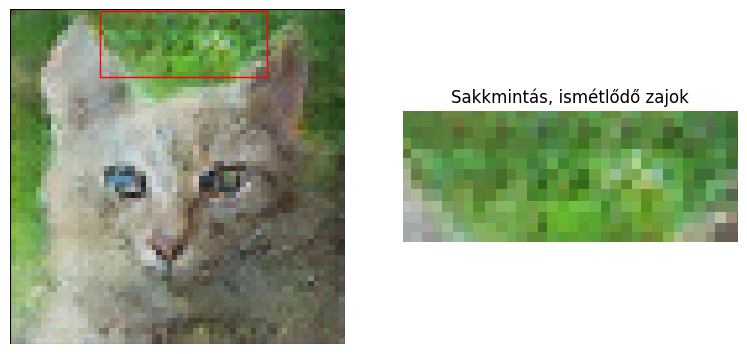

In [20]:
image = mpimg.imread('./images/chessboard.png')

xcoords = (80, 230)
ycoords = (60, 1)

fig, axes = plt.subplots(figsize=(8, 4), nrows=1, ncols=2, dpi=100)
plt.tight_layout()
# Create a Rectangle patch
rect = patches.Rectangle((xcoords[0], ycoords[1]),
                         xcoords[1]-xcoords[0], ycoords[0]-ycoords[1],
                         linewidth=1, edgecolor='r', facecolor='none')

axes[0].add_patch(rect)
axes[0].axis('off')
axes[0].imshow(image, interpolation='none')

axes[1].set_title("Sakkmintás, ismétlődő zajok")
axes[1].set_xlim(xcoords)
axes[1].set_ylim(ycoords)
axes[1].axis('off')

axes[1].imshow(image, interpolation='none')

# AnimalFaces-HQ datasetre betanított modell egy generált képe

## Sakkmintázat kiküszöbölése
A sakkmintázat kiküszöbölésére az alábbi cikkben a következő javaslatot találtam:
https://distill.pub/2016/deconv-checkerboard/
A cikkben a Dekonvolúciós rétegek helyett a Konvolúciós és UpSampling rétegeket ajánlották bilineáris interpolációval. Vagyis a felbontásnövelési feladatot elvették a dekonvolúciós rétegtől és egy tanítható-paraméter nélküli rétegre bízták a feladatot, aminek csak annyi a szerepe, hogy a felbontást növelje. Ezzel az ötlettel a sakkmintás zajt igen jól leredukálták a generált képeken. A tanítás előtti Generátor kimenetén is megfigyelhető, hogy a kép "lágyabb", kevésbé rendezettebb, mint az előző példában.

Viszont így önmagában nem volt szerencsém a modellt tanulásra bírnom és a BatchNormalization regularizációs rétegeket kellett beékelnem a modellbe. A technikát és a további alkalmazott regularizációs eljárásokat egy másik fejezeben foglalom majd össze.

In [21]:
def add_upsampling_unit(model,
                        filters, kernel_size):
    model.add(
        keras.layers.Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            padding='same',
            activation="relu",
            kernel_initializer="he_normal"
        )
    )
    model.add(keras.layers.UpSampling2D())


def make_generator_model(latent_dim):
    model = keras.Sequential()

    model.add(keras.layers.Reshape((1, 1, 100), input_shape=[latent_dim]))
    
    model.add(
        keras.layers.Conv2DTranspose(
            filters=512, kernel_size=4,
            strides=(1,1),
            padding='valid', activation="relu",
            kernel_initializer="he_normal"
        )
    )
    model.add(keras.layers.UpSampling2D())
    model.add(keras.layers.BatchNormalization())
    assert model.output_shape == (None, 8, 8, 512)
    add_upsampling_unit(model, 256, 4)
    model.add(keras.layers.BatchNormalization())
    assert model.output_shape == (None, 16, 16, 256)

    add_upsampling_unit(model, 128, 4)
    model.add(keras.layers.BatchNormalization())
    assert model.output_shape == (None, 32, 32, 128)

    add_upsampling_unit(model, 64, 4)
    assert model.output_shape == (None, 64, 64, 64)

    model.add(keras.layers.Conv2D(3, kernel_size=4, padding='same'))
    model.add(keras.layers.Activation("tanh"))
    assert model.output_shape == (None, 64, 64, 3)

    return model

In [22]:
tf.random.set_seed(22)
model = make_generator_model(latent_dim)
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 1, 1, 100)         0         
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 4, 4, 512)         819712    
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 8, 8, 512)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 512)         2048      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 8, 8, 256)         2097408   
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 16, 16, 256)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 256)      

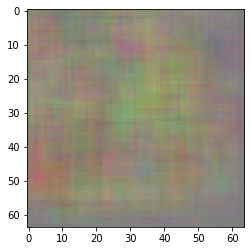

In [23]:
generated_images = model(noise, training=False)
gen_2 = generated_images[0].numpy()*127.5+127.5
plt.imshow((gen_2).astype("uint32"))

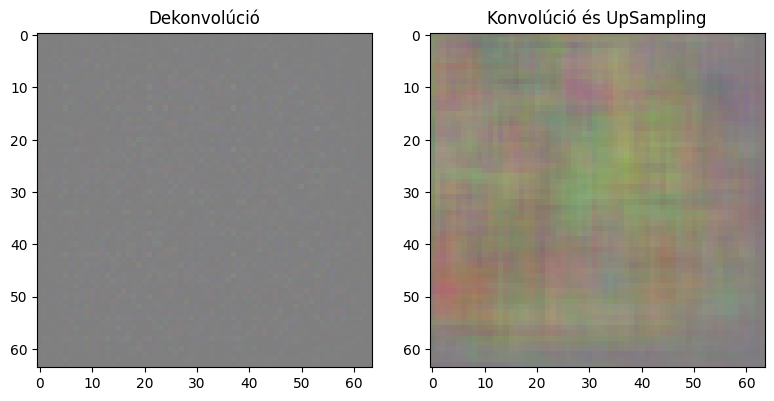

In [24]:
fig, axes = plt.subplots(figsize=(8, 4), nrows=1, ncols=2, dpi=100)
plt.tight_layout()
axes[0].set_title("Dekonvolúció")
axes[0].imshow((gen_1).astype("uint32"), interpolation='none')

axes[1].set_title("Konvolúció és UpSampling")
axes[1].imshow((gen_2).astype("uint32"), interpolation='none')